In [41]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=== VIDEO 4.2: BREAKOUT STRATEGY AUTOMATION ===")

# Download data
#UBAH KE BTC/ETH/ADA DLL DIBAWAH INI KL MAU TEST
btc_data = yf.download("ETH-USD", start="2025-01-01", end="2025-08-31", progress=False)

# Handle MultiIndex columns
if isinstance(btc_data.columns, pd.MultiIndex):
    btc_data.columns = btc_data.columns.droplevel(1)

print(f"Data loaded: {btc_data.shape[0]} days")

=== VIDEO 4.2: BREAKOUT STRATEGY AUTOMATION ===
Data loaded: 242 days


In [42]:
def add_essential_indicators(df, lookback_period=15):
    """
    Menambahkan hanya indikator yang diperlukan untuk sinyal breakout.
    """
    # Clean column names first (assuming standard yfinance names)
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]

    # Calculate Volume Moving Average and Ratio
    df['volume_ma'] = df['volume'].rolling(window=20).mean()
    # Handle division by zero for volume_ma
    df['volume_ratio'] = df['volume'] / df['volume_ma'].replace(0, np.nan) 

    # Calculate MACD
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Calculate Resistance levels
    df['resistance'] = df['high'].rolling(window=lookback_period).max()
    df['prev_resistance'] = df['resistance'].shift(1) # Previous day's resistance

    print("✅ Indikator esensial telah ditambahkan.")
    return df

def generate_breakout_signals(row, volume_threshold=1.2):
    """
    Generate breakout signals based on price and volume.
    """
    required_fields = ['close', 'prev_resistance', 'volume_ratio', 'macd', 'macd_signal']
    # Check if any required field is NaN for the current row
    if any(pd.isna(row[field]) for field in required_fields):
        return False # Cannot generate signal if data is missing

    # Breakout Up condition
    breakout_up = (
        row['close'] > row['prev_resistance'] and
        row['volume_ratio'] > volume_threshold and
        row['macd'] > row['macd_signal']
    )
    
    return breakout_up

# Terapkan indikator dan sinyal
btc_data = add_essential_indicators(btc_data)
# Apply the function row by row
btc_data['breakout_signal'] = btc_data.apply(generate_breakout_signals, axis=1) 
breakout_count = btc_data['breakout_signal'].sum()
print(f"Sinyal breakout terdeteksi: {breakout_count}")

✅ Indikator esensial telah ditambahkan.
Sinyal breakout terdeteksi: 16


In [43]:
print("\n=== TRADING STRATEGY SETUP ===")

# Initial trading parameters
initial_capital = 1000
current_cash = initial_capital
crypto_holdings = 0
trades = []
portfolio_value = [] # Track daily portfolio value

# Risk management and fees
stop_loss_pct = 0.03       # 3% stop loss
take_profit_ratio = 3.0    # Take profit at 3x the risk (stop loss %)
position_size_pct = 0.90   # Use 90% of available capital per trade
transaction_fee_pct = 0.001 # 0.1% fee per trade

print(f"Initial capital: ${initial_capital}")
print(f"Position size: {position_size_pct*100}% of available capital")
print(f"Transaction Fee: {transaction_fee_pct*100}% per trade")

# Trading state variables
in_position = False
entry_price = 0
stop_loss_price = 0
take_profit_price = 0
entry_date = None


=== TRADING STRATEGY SETUP ===
Initial capital: $1000
Position size: 90.0% of available capital
Transaction Fee: 0.1% per trade


In [44]:
def execute_breakout_trade(current_date, current_row):
    """
    Execute breakout trading logic with transaction fees.
    """
    global current_cash, crypto_holdings, in_position
    global entry_price, stop_loss_price, take_profit_price, entry_date

    # Pastikan nama kolom 'close' dan 'breakout_signal' sudah benar
    current_price = current_row['close'] 
    breakout_signal = current_row['breakout_signal']

    # Entry logic
    if not in_position and breakout_signal:
        position_value = current_cash * position_size_pct
        buy_fee = position_value * transaction_fee_pct
        total_cost = position_value + buy_fee

        if current_cash < total_cost:
            return None # Not enough cash

        shares_to_buy = position_value / current_price
        
        # Update state after buy
        current_cash -= total_cost
        crypto_holdings += shares_to_buy
        in_position = True
        entry_price = current_price
        entry_date = current_date # Assume current_date is pandas Timestamp
        
        # Set stop-loss and take-profit prices
        stop_loss_price = entry_price * (1 - stop_loss_pct)
        profit_target = entry_price * stop_loss_pct * take_profit_ratio
        take_profit_price = entry_price + profit_target

        trades.append({
            'action': 'BUY', 'date': current_date, 'price': current_price,
            'shares': shares_to_buy, 'value': position_value, 'fee': buy_fee,
            'cash_remaining': current_cash, 'stop_loss': stop_loss_price,
            'take_profit': take_profit_price
        })
        
        # Return formatted string for buy action
        return f"BUY: {shares_to_buy:.4f} crypto @ ${current_price:.2f} (Fee: ${buy_fee:.2f})"

    # Exit logic
    elif in_position:
        exit_signal = False
        exit_reason = ""

        if current_price <= stop_loss_price:
            exit_signal = True
            exit_reason = "STOP_LOSS"
        elif current_price >= take_profit_price:
            exit_signal = True
            exit_reason = "TAKE_PROFIT"
        # Momentum weakening exit condition (MACD crossing below signal)
        elif 'macd' in current_row and 'macd_signal' in current_row and \
             current_row['macd'] < current_row['macd_signal']: # Ensure columns exist
            exit_signal = True
            exit_reason = "MOMENTUM_WEAK"

        if exit_signal:
            exit_value = crypto_holdings * current_price
            sell_fee = exit_value * transaction_fee_pct
            
            # Find the corresponding buy trade value for profit calculation
            # Assumes the last trade in the list is the buy trade for this position
            buy_trade = trades[-1] if trades and trades[-1]['action'] == 'BUY' else None
            # Calculate profit based on net value (value - fee) for buy and sell
            if buy_trade:
                profit_loss = (exit_value - sell_fee) - (buy_trade['value'] - buy_trade['fee'])
            else: 
                profit_loss = (exit_value - sell_fee) # Fallback if buy trade not found correctly
            
            profit_pct = (current_price - entry_price) / entry_price * 100

            # Update state after sell
            current_cash += (exit_value - sell_fee)
            crypto_holdings = 0
            in_position = False

            trades.append({
                'action': 'SELL', 'date': current_date, 'price': current_price,
                'shares': 0, # Or record shares sold: crypto_holdings before reset
                'value': exit_value, 'fee': sell_fee,
                'cash_remaining': current_cash, 'profit_loss': profit_loss,
                'profit_pct': profit_pct, 'exit_reason': exit_reason,
                'days_held': (current_date - entry_date).days if entry_date else None # Calculate holding period
            })
            
            # Return formatted string for sell action
            return f"SELL: {exit_reason} @ ${current_price:.2f} | Net P&L: ${profit_loss:+.2f} ({profit_pct:+.2f}%)"

    return None # No action taken

In [45]:
print("\n=== RUNNING BREAKOUT STRATEGY ===")
trade_log = [] # Log messages from execute_breakout_trade

# Ensure portfolio_value list is initialized if not already done
if 'portfolio_value' not in locals():
    portfolio_value = []

for date, row in btc_data.iterrows():
    trade_result = execute_breakout_trade(date, row)
    
    # Calculate current portfolio value for this day
    current_portfolio = current_cash
    if in_position:
        # Make sure 'close' column name is correct
        current_portfolio += crypto_holdings * row['close'] 
        
    portfolio_value.append({'date': date, 'portfolio_value': current_portfolio})
    
    # Log the trade message if a trade occurred
    if trade_result:
        trade_log.append(f"{date.strftime('%Y-%m-%d')}: {trade_result}")

# Convert portfolio history to DataFrame after the loop
portfolio_df = pd.DataFrame(portfolio_value).set_index('date')

# Print the trade log (optional, but helpful for debugging)
print("\n--- Trade Log ---")
if trade_log:
    for entry in trade_log:
        print(entry)
else:
    print("No trades executed during this period.")


=== RUNNING BREAKOUT STRATEGY ===

--- Trade Log ---
2025-04-22: BUY: 0.5121 crypto @ $1757.33 (Fee: $0.90)
2025-05-08: SELL: TAKE_PROFIT @ $2206.51 | Net P&L: $+229.81 (+25.56%)
2025-05-09: BUY: 0.4712 crypto @ $2345.51 (Fee: $1.11)
2025-05-10: SELL: TAKE_PROFIT @ $2582.42 | Net P&L: $+111.52 (+10.10%)
2025-05-13: BUY: 0.4491 crypto @ $2680.13 (Fee: $1.20)
2025-05-15: SELL: STOP_LOSS @ $2546.86 | Net P&L: $-59.79 (-4.97%)
2025-07-09: BUY: 0.4142 crypto @ $2770.78 (Fee: $1.15)
2025-07-15: SELL: TAKE_PROFIT @ $3139.89 | Net P&L: $+152.73 (+13.32%)
2025-07-16: BUY: 0.3805 crypto @ $3371.51 (Fee: $1.28)
2025-07-20: SELL: TAKE_PROFIT @ $3759.47 | Net P&L: $+147.49 (+11.51%)
2025-08-09: BUY: 0.3315 crypto @ $4263.60 (Fee: $1.41)
2025-08-13: SELL: TAKE_PROFIT @ $4756.28 | Net P&L: $+163.17 (+11.56%)


In [46]:
# ==============================================================================
# RUN BACKTEST LOOP
# ==============================================================================
print("\n=== RUNNING BREAKOUT STRATEGY BACKTEST ===")
trade_log = [] # Log messages from execute_breakout_trade
portfolio_value = [] # Reset portfolio history tracker

# Ensure trading state variables are reset if re-running this cell
current_cash = initial_capital
crypto_holdings = 0
in_position = False
entry_price = 0
stop_loss_price = 0
take_profit_price = 0
entry_date = None
trades = [] # Reset trade list

for date, row in btc_data.iterrows():
    trade_result = execute_breakout_trade(date, row)
    
    # Calculate current portfolio value for this day
    current_portfolio = current_cash
    if in_position:
        current_portfolio += crypto_holdings * row['close'] 
        
    portfolio_value.append({'date': date, 'portfolio_value': current_portfolio})
    
    # Log the trade message if a trade occurred
    if trade_result:
        trade_log.append(f"{date.strftime('%Y-%m-%d')}: {trade_result}")

# Convert portfolio history to DataFrame after the loop
portfolio_df = pd.DataFrame(portfolio_value).set_index('date')

# Print the trade log (optional)
# print("\n--- Trade Log ---")
# if trade_log:
#     for entry in trade_log:
#         print(entry)
# else:
#     print("No trades executed during this period.")


# ==============================================================================
# CALCULATE & DISPLAY PERFORMANCE RESULTS
# ==============================================================================
print("\n" + "="*60)
print("BREAKOUT STRATEGY PERFORMANCE RESULTS")
print("="*60)

# Calculate final performance metrics
final_portfolio_value = portfolio_df['portfolio_value'].iloc[-1]
total_return = final_portfolio_value - initial_capital
# Handle division by zero if initial capital is 0
total_return_pct = (total_return / initial_capital) * 100 if initial_capital > 0 else 0

print("PERFORMANCE SUMMARY (Net of Fees):")
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio: ${final_portfolio_value:,.2f}")
# Corrected format specifier for total_return
print(f"Total Return: ${total_return:+,.2f} ({total_return_pct:+.2f}%)") 

# Calculate Buy & Hold benchmark return for the same period
btc_start_price = btc_data['close'].iloc[0]
btc_end_price = btc_data['close'].iloc[-1]
btc_return = (btc_end_price / btc_start_price - 1) * 100 if btc_start_price > 0 else 0

print(f"\nBENCHMARK COMPARISON:")
print(f"Crypto Buy & Hold Return: {btc_return:+.2f}%")

# Calculate trade statistics
# Focus only on completed trades (SELL actions) for win rate and profit
completed_trades = [t for t in trades if t['action'] == 'SELL']
total_trades_completed = len(completed_trades)

if total_trades_completed > 0:
    winning_trades = [t for t in completed_trades if t['profit_loss'] > 0]
    win_rate = len(winning_trades) / total_trades_completed * 100
    # Use numpy.mean which handles empty lists gracefully (returns NaN)
    avg_profit = np.mean([t['profit_loss'] for t in completed_trades]) 
    total_fees_paid = sum(t['fee'] for t in trades) # Sum fees from ALL trades (BUY and SELL)

    print(f"\nTRADE STATISTICS:")
    print(f"Total Completed Trades (Sell): {total_trades_completed}")
    print(f"Win Rate: {win_rate:.1f}%")
    print(f"Average Net P&L per completed trade: ${avg_profit:+.2f}")
    print(f"Total Fees Paid: ${total_fees_paid:.2f}")
else:
    print("\nNo completed trades (SELL orders) during this period")


=== RUNNING BREAKOUT STRATEGY BACKTEST ===

BREAKOUT STRATEGY PERFORMANCE RESULTS
PERFORMANCE SUMMARY (Net of Fees):
Initial Capital: $1,000.00
Final Portfolio: $1,730.83
Total Return: $+730.83 (+73.08%)

BENCHMARK COMPARISON:
Crypto Buy & Hold Return: +30.44%

TRADE STATISTICS:
Total Completed Trades (Sell): 6
Win Rate: 83.3%
Average Net P&L per completed trade: $+124.16
Total Fees Paid: $14.85


In [47]:
# ==============================================================================
# RISK & PERFORMANCE METRICS
# ==============================================================================

print(f"\nRISK MANAGEMENT:")
# Calculate Drawdown
portfolio_df['peak'] = portfolio_df['portfolio_value'].expanding().max()
portfolio_df['drawdown'] = (portfolio_df['portfolio_value'] / portfolio_df['peak']) - 1
max_drawdown = portfolio_df['drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Volatility analysis
daily_returns = portfolio_df['portfolio_value'].pct_change().dropna()
# Ensure there are returns to calculate volatility
volatility = daily_returns.std() * np.sqrt(252) * 100 if not daily_returns.empty else 0 # Annualized volatility (assuming 252 trading days)
print(f"Strategy Volatility: {volatility:.2f}% (annualized)")

# Risk-adjusted return (Sharpe-like ratio)
risk_free_rate = 0.02 # Assume 2% risk-free rate (adjust if needed)
# Ensure total_return_pct is defined from the previous step (needs to be in decimal form for calculation)
total_return_decimal = total_return_pct / 100 
excess_return = total_return_decimal - risk_free_rate
# Calculate Sharpe ratio, handle division by zero if volatility is 0
sharpe_ratio = excess_return / (volatility / 100) if volatility > 0 else 0 
print(f"Risk-Adjusted Return (Sharpe Ratio): {sharpe_ratio:.2f}")


RISK MANAGEMENT:
Maximum Drawdown: -4.74%
Strategy Volatility: 25.77% (annualized)
Risk-Adjusted Return (Sharpe Ratio): 2.76


In [48]:
print(f"\nDETAILED TRADE LOG:")
print("-" * 80)
for log_entry in trade_log:
    print(log_entry)


DETAILED TRADE LOG:
--------------------------------------------------------------------------------
2025-04-22: BUY: 0.5121 crypto @ $1757.33 (Fee: $0.90)
2025-05-08: SELL: TAKE_PROFIT @ $2206.51 | Net P&L: $+229.81 (+25.56%)
2025-05-09: BUY: 0.4712 crypto @ $2345.51 (Fee: $1.11)
2025-05-10: SELL: TAKE_PROFIT @ $2582.42 | Net P&L: $+111.52 (+10.10%)
2025-05-13: BUY: 0.4491 crypto @ $2680.13 (Fee: $1.20)
2025-05-15: SELL: STOP_LOSS @ $2546.86 | Net P&L: $-59.79 (-4.97%)
2025-07-09: BUY: 0.4142 crypto @ $2770.78 (Fee: $1.15)
2025-07-15: SELL: TAKE_PROFIT @ $3139.89 | Net P&L: $+152.73 (+13.32%)
2025-07-16: BUY: 0.3805 crypto @ $3371.51 (Fee: $1.28)
2025-07-20: SELL: TAKE_PROFIT @ $3759.47 | Net P&L: $+147.49 (+11.51%)
2025-08-09: BUY: 0.3315 crypto @ $4263.60 (Fee: $1.41)
2025-08-13: SELL: TAKE_PROFIT @ $4756.28 | Net P&L: $+163.17 (+11.56%)



Creating strategy visualization...


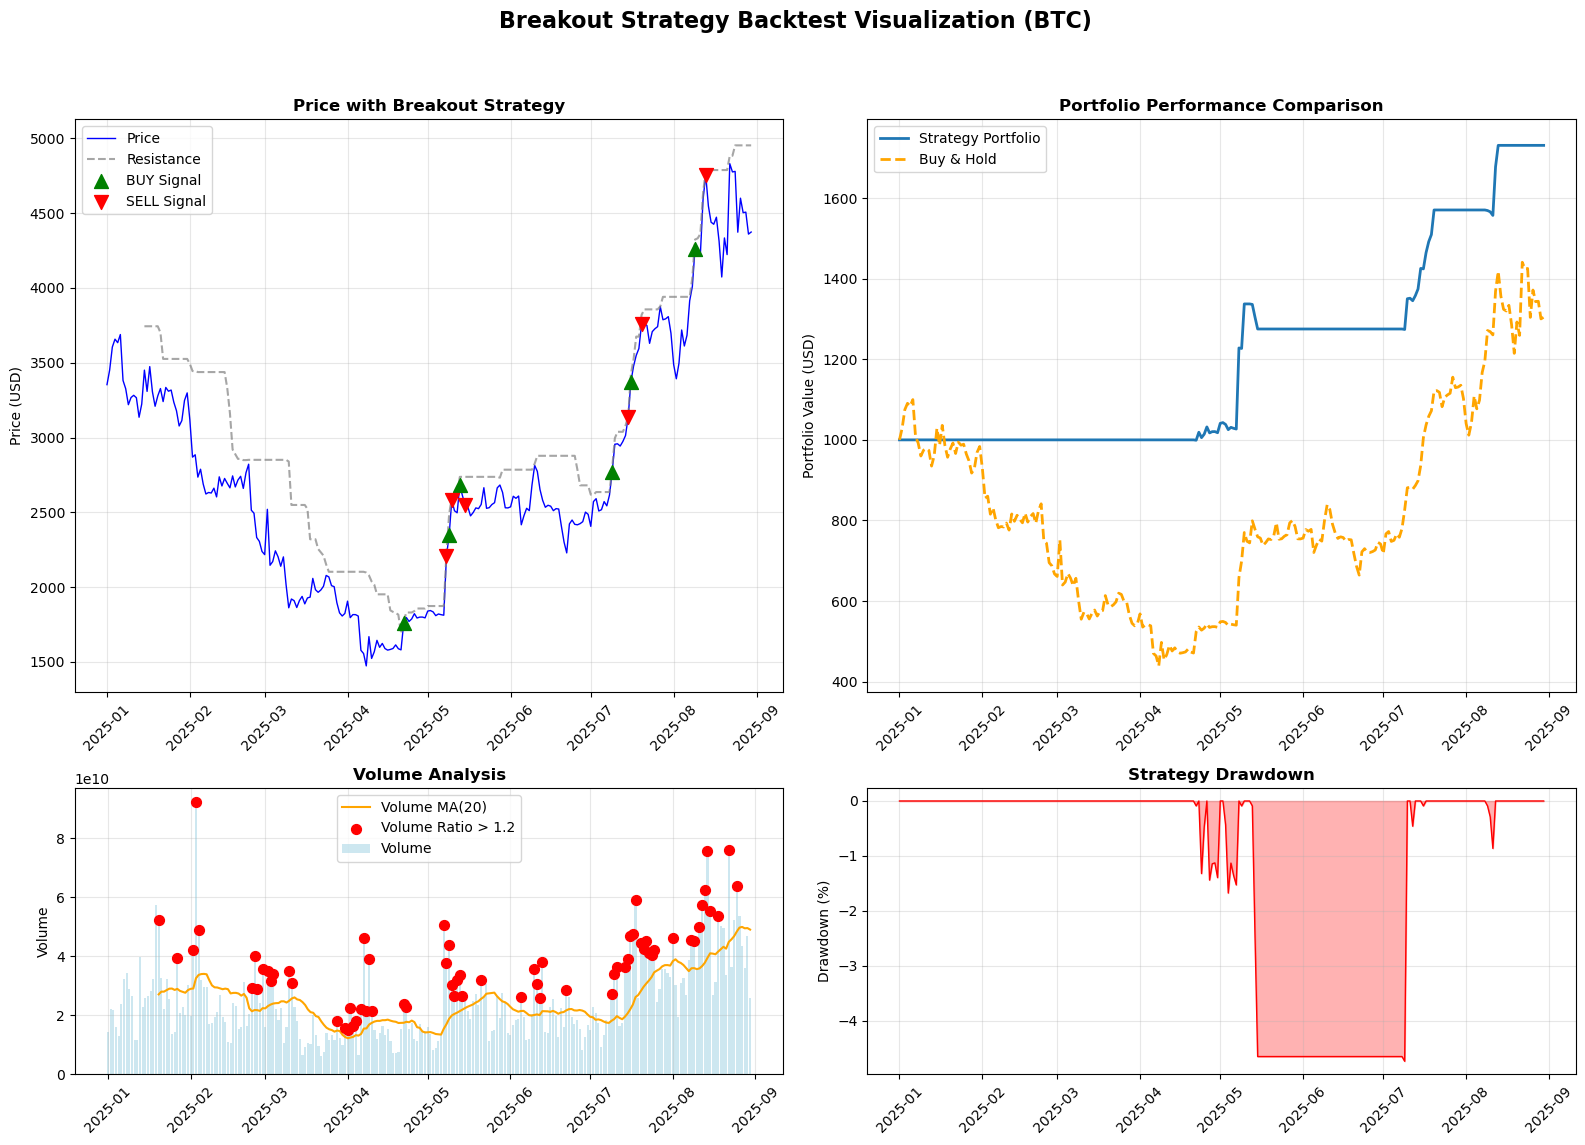

In [49]:
print("\nCreating strategy visualization...")
# Make sure portfolio_df exists and has the required columns
if 'portfolio_df' in locals() and not portfolio_df.empty:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 1]})
    fig.suptitle('Breakout Strategy Backtest Visualization (BTC)', fontsize=16, fontweight='bold')

    # --- Chart 1: Price with Signals & Resistance ---
    ax1.plot(btc_data.index, btc_data['close'], label='Price', linewidth=1, color='blue')
    # Plot resistance if the column exists
    if 'resistance' in btc_data.columns:
        ax1.plot(btc_data.index, btc_data['resistance'], label='Resistance', linestyle='--', alpha=0.7, color='grey')

    # Get buy/sell trades from the 'trades' list (should be populated from backtest)
    buy_trades = [t for t in trades if t['action'] == 'BUY']
    sell_trades = [t for t in trades if t['action'] == 'SELL']

    if buy_trades:
        buy_dates = [t['date'] for t in buy_trades]
        buy_prices = [t['price'] for t in buy_trades]
        ax1.scatter(buy_dates, buy_prices, color='green', marker='^', s=100, label='BUY Signal', zorder=5)
    if sell_trades:
        sell_dates = [t['date'] for t in sell_trades]
        sell_prices = [t['price'] for t in sell_trades]
        ax1.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, label='SELL Signal', zorder=5)

    ax1.set_title('Price with Breakout Strategy', fontweight='bold')
    ax1.set_ylabel('Price (USD)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- Chart 2: Portfolio Performance Comparison ---
    ax2.plot(portfolio_df.index, portfolio_df['portfolio_value'], label='Strategy Portfolio', linewidth=2)
    # Calculate Buy & Hold Portfolio Value
    btc_portfolio = initial_capital * (btc_data['close'] / btc_data['close'].iloc[0])
    ax2.plot(btc_data.index, btc_portfolio, label='Buy & Hold', linewidth=2, color='orange', linestyle='--')
    ax2.set_title('Portfolio Performance Comparison', fontweight='bold')
    ax2.set_ylabel('Portfolio Value (USD)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # --- Chart 3: Volume Analysis (MODIFIED) ---
    ax3.bar(btc_data.index, btc_data['volume'], alpha=0.6, color='lightblue', label='Volume')
    # Plot volume MA if it exists
    if 'volume_ma' in btc_data.columns:
        ax3.plot(btc_data.index, btc_data['volume_ma'], color='orange', label='Volume MA(20)')
    
    # Filter hari dengan volume ratio > 1.2
    if 'volume_ratio' in btc_data.columns:
        high_volume_days = btc_data[btc_data['volume_ratio'] > 1.2]
        # Tambahkan penanda (scatter plot) pada chart volume
        if not high_volume_days.empty:
            ax3.scatter(high_volume_days.index, high_volume_days['volume'],
                        color='red',
                        marker='o',
                        s=50,
                        label='Volume Ratio > 1.2',
                        zorder=5) # zorder agar tampil di atas bar

    ax3.set_title('Volume Analysis', fontweight='bold')
    ax3.set_ylabel('Volume')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # --- Chart 4: Drawdown ---
    # Ensure 'drawdown' column exists from the risk calculation cell
    if 'drawdown' in portfolio_df.columns:
        ax4.fill_between(portfolio_df.index, portfolio_df['drawdown'] * 100, 0, alpha=0.3, color='red', label='Drawdown') # Multiply by 100 for percentage
        ax4.plot(portfolio_df.index, portfolio_df['drawdown'] * 100, color='red', linewidth=1)
        ax4.set_title('Strategy Drawdown', fontweight='bold')
        ax4.set_ylabel('Drawdown (%)')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.set_title('Drawdown Data Not Available')

    # Rotate x-axis labels for all subplots for better readability
    for ax in [ax1, ax2, ax3, ax4]:
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

else:
    print("Portfolio DataFrame ('portfolio_df') not found or empty. Cannot create visualization.")